🔍 환자 [1.2.826.0.1.3680043.780] 전처리 시뮬레이션 시작...
⏳ 볼륨 로딩 중...
✅ 골절 슬라이스 발견: [86 87]


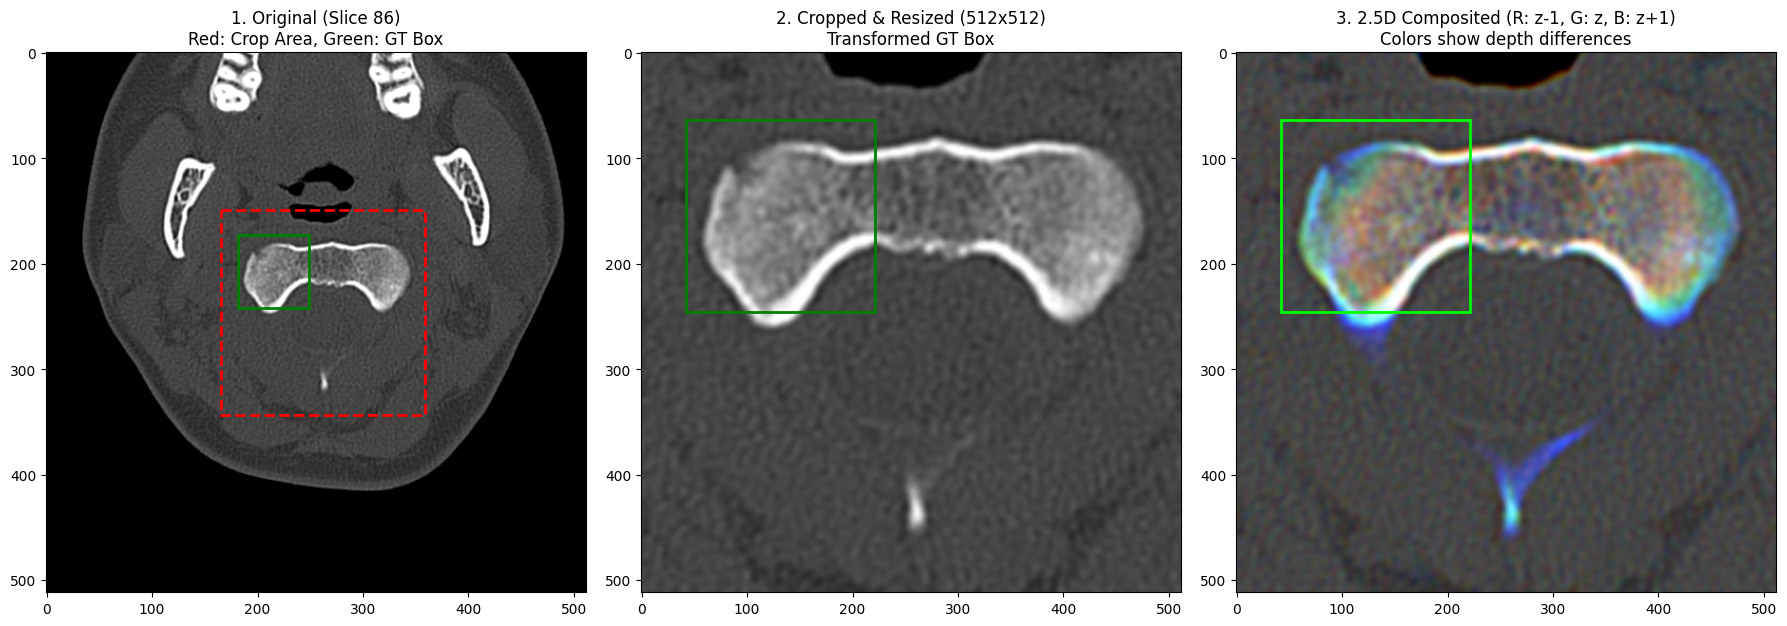

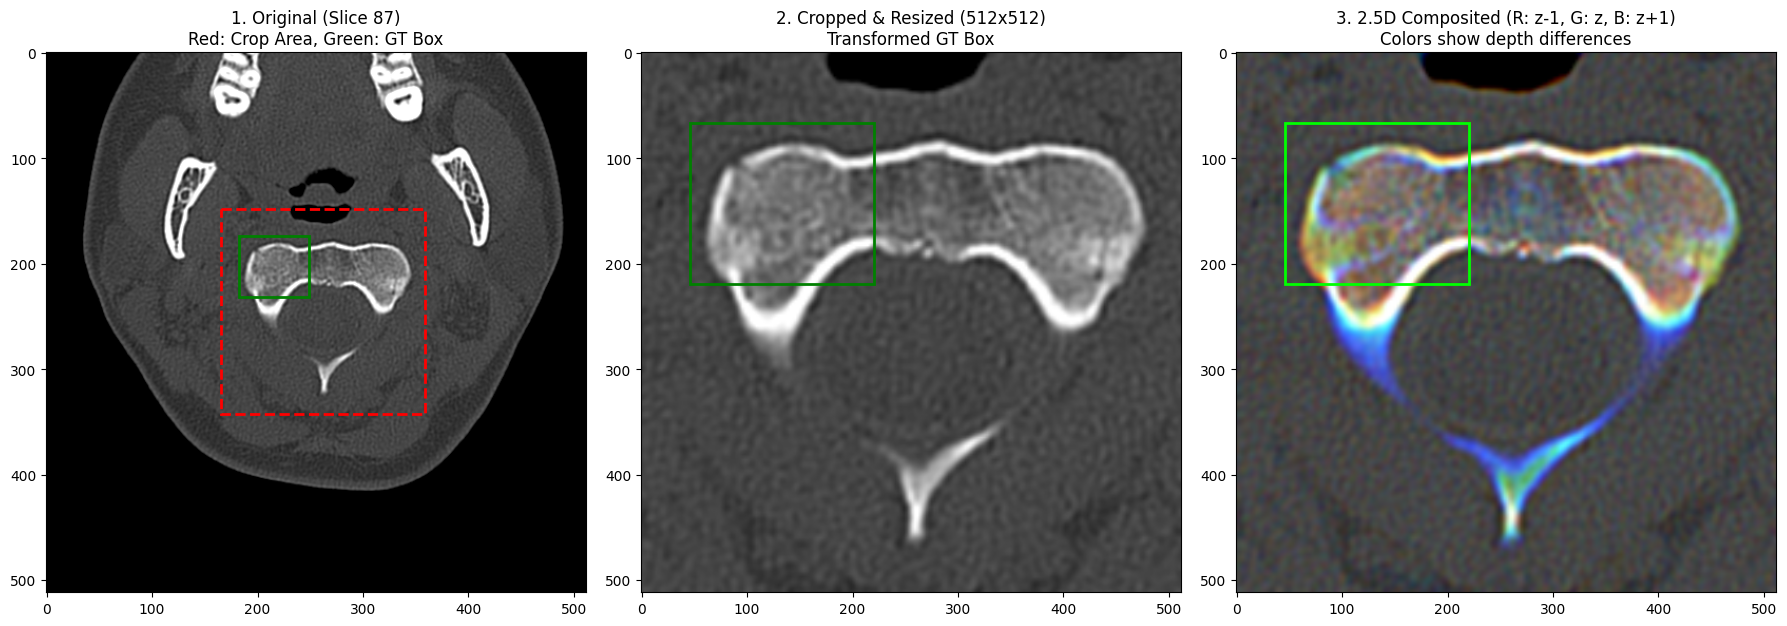

In [1]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2
import pandas as pd
import ast
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ==========================================
# [설정] 본인 경로 확인
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'

# 골절이 확실히 있는 환자 UID 하나를 선택하세요! (아래는 예시)
SAMPLE_UID = '1.2.826.0.1.3680043.780'  

DICOM_ROOT_DIRS = [
    os.path.join(BASE_DIR, '1_mask_and_box', 'train_images'),
    os.path.join(BASE_DIR, '3_only_box', 'train_images'),
]
MASK_DIR = os.path.join(BASE_DIR, 'seg_pseudo_masks') 
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'filtered_train_bounding_boxes.csv')

WL, WW = 500, 2000
TARGET_SIZE = 512
MARGIN_RATIO = 0.2 

# ==========================================
# [유틸리티 함수] (기존 코드 동일)
# ==========================================
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

def get_mask_bbox(mask_slice):
    rows = np.any(mask_slice > 0, axis=1)
    cols = np.any(mask_slice > 0, axis=0)
    if not np.any(rows) or not np.any(cols): return None
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def make_square_box(x1, y1, x2, y2, img_w, img_h, margin=0.2):
    w = x2 - x1
    h = y2 - y1
    cx, cy = x1 + w // 2, y1 + h // 2
    max_side = max(w, h)
    new_size = int(max_side * (1 + margin))
    half_size = new_size // 2
    new_x1 = max(0, cx - half_size)
    new_y1 = max(0, cy - half_size)
    new_x2 = min(img_w, cx + half_size)
    new_y2 = min(img_h, cy + half_size)
    if new_x2 <= new_x1 or new_y2 <= new_y1: return 0, 0, img_w, img_h
    return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

def get_slice_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# ==========================================
# [시각화 메인] 
# ==========================================
def visualize_step_by_step():
    print(f"🔍 환자 [{SAMPLE_UID}] 전처리 시뮬레이션 시작...")
    
    # 1. 라벨 데이터 로드
    bbox_df = pd.read_csv(BBOX_CSV_PATH)
    pat_bbox_df = bbox_df[bbox_df['StudyInstanceUID'] == SAMPLE_UID]
    
    if len(pat_bbox_df) == 0:
        print("❌ 경고: 이 환자는 골절(Bounding Box) 데이터가 없습니다. 다른 UID를 선택하세요.")
        return

    # 2. DICOM 폴더 찾기
    dicom_dir = None
    for root in DICOM_ROOT_DIRS:
        temp_path = os.path.join(root, SAMPLE_UID)
        if os.path.exists(temp_path):
            dicom_dir = temp_path
            break
            
    if dicom_dir is None:
        print("❌ DICOM 폴더를 찾을 수 없습니다.")
        return
        
    # 3. 데이터 로드 (메타, 볼륨, 마스크)
    dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    dcm_meta = []
    for f in dcm_files:
        slice_num = get_slice_number(f)
        ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
        dcm_meta.append({
            'filename': f, 'full_path': os.path.join(dicom_dir, f),
            'slice_number': slice_num, 
            'z_pos': float(ds.ImagePositionPatient[2]),
            'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
            'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
        })
    dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
    
    print("⏳ 볼륨 로딩 중...")
    full_vol = []
    for m in dcm_meta:
        ds = pydicom.dcmread(m['full_path'])
        px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
        full_vol.append(apply_windowing(px, WL, WW))
    full_vol = np.stack(full_vol, axis=0)
    
    mask_path = os.path.join(MASK_DIR, f"{SAMPLE_UID}_mask.nii.gz")
    mask_itk = sitk.ReadImage(mask_path)
    mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
    mask_vol = np.flip(mask_vol, axis=(0, 1))

    # 4. 시각화할 '골절이 있는 슬라이스' 5장 추출
    fracture_slices = pat_bbox_df['slice_number'].unique()
    target_slices = fracture_slices[:5] # 최대 5장만
    
    print(f"✅ 골절 슬라이스 발견: {target_slices}")
    
    for z_idx, meta in enumerate(dcm_meta):
        current_slice_num = meta['slice_number']
        
        # 타겟 슬라이스(골절 있는 곳)만 시각화
        if current_slice_num not in target_slices:
            continue
            
        if z_idx >= len(mask_vol): break
        m_slice = mask_vol[z_idx]
        img_slice = full_vol[z_idx]
        
        # --- [Step 1] Crop Box 계산 ---
        mask_bbox = get_mask_bbox(m_slice)
        if mask_bbox is None: continue
        mx1, my1, mx2, my2 = mask_bbox
        
        relevant_boxes = pat_bbox_df[pat_bbox_df['slice_number'] == current_slice_num]
        final_x1, final_y1, final_x2, final_y2 = mx1, my1, mx2, my2
        
        gt_boxes_orig = []
        if len(relevant_boxes) > 0:
            for _, row in relevant_boxes.iterrows():
                bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                gt_boxes_orig.append((bx, by, bw, bh))
                bx2, by2 = bx + bw, by + bh
                final_x1 = min(final_x1, bx)
                final_y1 = min(final_y1, by)
                final_x2 = max(final_x2, bx2)
                final_y2 = max(final_y2, by2)
                
        ori_h, ori_w = m_slice.shape
        cx1, cy1, cx2, cy2 = make_square_box(final_x1, final_y1, final_x2, final_y2, ori_w, ori_h, MARGIN_RATIO)
        crop_w, crop_h = cx2 - cx1, cy2 - cy1
        
        # --- [Step 2] 3채널 크롭 및 리사이즈 ---
        z_prev = max(0, z_idx - 1)
        z_next = min(len(full_vol) - 1, z_idx + 1)
        img_3ch = np.stack([full_vol[z_prev], full_vol[z_idx], full_vol[z_next]], axis=0) 
        
        cropped_3ch = img_3ch[:, cy1:cy2, cx1:cx2]
        cropped_hwc = np.transpose(cropped_3ch, (1, 2, 0))
        resized_hwc = cv2.resize(cropped_hwc, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
        
        # --- [Step 3] BBox 변환 계산 ---
        scale_x = TARGET_SIZE / crop_w
        scale_y = TARGET_SIZE / crop_h
        gt_boxes_resized = []
        
        for (bx, by, bw, bh) in gt_boxes_orig:
            new_x = (bx - cx1) * scale_x
            new_y = (by - cy1) * scale_y
            new_w = bw * scale_x
            new_h = bh * scale_y
            gt_boxes_resized.append((new_x, new_y, new_w, new_h))

        # =======================================================
        # 🎨 시각화 (1행 3열 그래프)
        # =======================================================
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # [1] 원본 이미지 + Crop 예정 영역
        axes[0].imshow(img_slice, cmap='gray')
        axes[0].set_title(f"1. Original (Slice {current_slice_num})\nRed: Crop Area, Green: GT Box")
        
        # Crop Box 그리기 (빨간색)
        rect_crop = patches.Rectangle((cx1, cy1), crop_w, crop_h, linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
        axes[0].add_patch(rect_crop)
        
        # 원본 GT Box 그리기 (초록색)
        for (bx, by, bw, bh) in gt_boxes_orig:
            rect_gt = patches.Rectangle((bx, by), bw, bh, linewidth=2, edgecolor='g', facecolor='none')
            axes[0].add_patch(rect_gt)
            
        # [2] 크롭 & 리사이즈 된 결과 (현재 슬라이스만)
        # 3채널 중 현재 슬라이스는 index 1 (가운데)
        center_slice_resized = resized_hwc[:, :, 1]
        axes[1].imshow(center_slice_resized, cmap='gray')
        axes[1].set_title(f"2. Cropped & Resized ({TARGET_SIZE}x{TARGET_SIZE})\nTransformed GT Box")
        
        # 변환된 GT Box 그리기 (초록색)
        for (nx, ny, nw, nh) in gt_boxes_resized:
            rect_gt_new = patches.Rectangle((nx, ny), nw, nh, linewidth=2, edgecolor='g', facecolor='none')
            axes[1].add_patch(rect_gt_new)

        # [3] 2.5D (3채널) 컬러 합성 시각화
        # z-1을 R, z를 G, z+1을 B 채널에 넣어서 컬러로 보여줌
        # 색이 섞여 보이면 앞/뒤 뼈가 움직인(변화한) 부분입니다.
        rgb_vis = np.clip(resized_hwc, 0, 1) # 0~1 정규화 유지
        axes[2].imshow(rgb_vis)
        axes[2].set_title("3. 2.5D Composited (R: z-1, G: z, B: z+1)\nColors show depth differences")
        
        for (nx, ny, nw, nh) in gt_boxes_resized:
            rect_gt_new = patches.Rectangle((nx, ny), nw, nh, linewidth=2, edgecolor='lime', facecolor='none')
            axes[2].add_patch(rect_gt_new)
            
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    visualize_step_by_step()